## Aditya Manjunatha

In [1]:
!apt install torchviz
!pip install torchviz

# Importing torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F#All activation functions are present here
import torch.optim as optim # Optimizer is stored here
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
import torchvision.models as models
from torchviz import make_dot  #visualize computational graph
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Importing other packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
import os
from PIL import Image

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# To test whether GPU instance is present in the system or not.
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)

device = torch.device("cuda" if use_cuda else "cpu")
print(device)

Using PyTorch version: 2.4.1+cu121 CUDA: True
cuda


In [ ]:
# Set directory and CSV paths
from pathlib import Path 

DATASET_DIR = Path("/home/maditya/Desktop/Feather classifier/feathersv1-dataset-master")
TRAIN_CSV = DATASET_DIR / "data" / "train_top_50_species.csv"
TEST_CSV = DATASET_DIR / "data" / "test_test_50_species.csv"

IMG_WIDTH, IMG_HEIGHT = 240, 40
BATCH_SIZE = 16



In [4]:
def load_data(csv_file, dataset_dir, label_type="species"):
    # Read image paths
    image_paths = []
    labels = []

    with open(csv_file, "r") as file:
        file.readline()  # skip header
        for line in file:
            parts = [x.lower().replace(" ", "_") for x in line.strip().split(",")]
            image_path = dataset_dir / "images" / parts[1] / parts[2] / parts[0]
            image_paths.append(image_path.as_posix())
            labels.append(parts[2] if label_type == "species" else parts[1])

    return pd.DataFrame({"imgpath": image_paths, "label": labels})
    
train_df = load_data(TRAIN_CSV, DATASET_DIR)
test_df = load_data(TEST_CSV, DATASET_DIR)


In [5]:
label_encoder = LabelEncoder()
train_df['encoded_labels'] = label_encoder.fit_transform(train_df['label'])
test_df['encoded_labels'] = label_encoder.transform(test_df['label'])

# Print unique encoded labels and their mappings
print("Encoded Label \t Original Label")
for encoded_label, original_label in enumerate(label_encoder.classes_):
    print(f"{encoded_label} \t\t {original_label}")


Encoded Label 	 Original Label
0 		 accipiter_gentilis
1 		 accipiter_nisus
2 		 acrocephalus_palustris
3 		 acrocephalus_schoenobaenus
4 		 acrocephalus_scirpaceus
5 		 actitis_hypoleucos
6 		 aix_galericulata
7 		 aix_sponsa
8 		 alca_torda
9 		 alcedo_atthis
10 		 anas_acuta
11 		 anas_clypeata
12 		 anas_crecca
13 		 anas_platyrhynchos
14 		 anser_anser
15 		 apus_apus
16 		 aquila_chrysaetos
17 		 asio_flammeus
18 		 asio_otus
19 		 athene_noctua
20 		 aythya_ferina
21 		 bombycilla_garrulus
22 		 botaurus_stellaris
23 		 calidris_alpina
24 		 calidris_canutus
25 		 caprimulgus_climacurus
26 		 caprimulgus_europaeus
27 		 carduelis_cannabina
28 		 carduelis_carduelis
29 		 charadrius_dubius
30 		 chenonetta_jubata
31 		 chloris_chloris
32 		 circus_aeruginosus
33 		 circus_cyaneus
34 		 dendrocopos_major
35 		 garrulus_glandarius
36 		 haematopus_ostralegus
37 		 larus_canus
38 		 larus_crassirostris
39 		 larus_fuscus
40 		 milvus_milvus
41 		 phasianus_colchicus
42 		 phoenicopt

In [6]:
class CustomFeatherDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'imgpath']
        image = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'encoded_labels']
        
        if self.transform:
            image = self.transform(image)
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ColorJitter(brightness=0.15, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [7]:
# Create datasets
train_dataset = CustomFeatherDataset(train_df, transform=train_transform)
test_dataset = CustomFeatherDataset(test_df, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 8251
Test dataset size: 2063


In [8]:
for images, labels in train_loader:
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    #print("Labels batch values:", labels)
    #print("Images[0]", images[0])
    #print("Labels[0]", labels[0])
    break  # Just print for one batch

for images, labels in test_loader:
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    break

Images batch shape: torch.Size([32, 3, 240, 40])
Labels batch shape: torch.Size([32])
Images batch shape: torch.Size([32, 3, 240, 40])
Labels batch shape: torch.Size([32])


### Training a EfficientNetB3 model ( commented out other models)

In [ ]:
# Load the pretrained EfficientNetB3 model
model = models.efficientnet_b3(pretrained=True)
#model = models.resnet50(pretrained=True)
#model = models.denseNet121(pretrained=True)
#model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 50)
model = model.to(device)

# Set BatchNorm layers as non-trainable for fine-tuning
for param in model.parameters():
    param.requires_grad = True

for module in model.modules():
    if isinstance(module, nn.BatchNorm2d):
        module.eval()  # Set to evaluation mode
        for param in module.parameters():
            param.requires_grad = False

# CHange above too
BATCH_SIZE = 16
lr = 0.001
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
valid_losses = []
train_acc = []
valid_acc = []
best_valid_loss = float('inf')

print(f"Batch size: {BATCH_SIZE}, Learning rate: {lr}, Number of epochs: {num_epochs}")


/home/maditya/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maditya/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Batch size: 32, Learning rate: 0.001, Number of epochs: 10



Epoch 1/10


Validating: 100%|██████████| 65/65 [00:03<00:00, 17.11it/s]


Epoch 1/10, Train Loss: 1.7526, Train Acc: 0.5333, Val Loss: 0.6819, Val Acc: 0.8022
Model weights saved for epoch 1 with validation loss: 0.6819

Epoch 2/10


Validating: 100%|██████████| 65/65 [00:03<00:00, 17.07it/s]


Epoch 2/10, Train Loss: 0.5371, Train Acc: 0.8401, Val Loss: 0.3602, Val Acc: 0.8924
Model weights saved for epoch 2 with validation loss: 0.3602

Epoch 3/10


Validating: 100%|██████████| 65/65 [00:03<00:00, 16.88it/s]


Epoch 3/10, Train Loss: 0.2920, Train Acc: 0.9144, Val Loss: 0.2366, Val Acc: 0.9341
Model weights saved for epoch 3 with validation loss: 0.2366

Epoch 4/10


Validating: 100%|██████████| 65/65 [00:03<00:00, 17.18it/s]


Epoch 4/10, Train Loss: 0.2320, Train Acc: 0.9259, Val Loss: 0.2976, Val Acc: 0.9200

Epoch 5/10


Validating: 100%|██████████| 65/65 [00:03<00:00, 17.08it/s]


Epoch 5/10, Train Loss: 0.1757, Train Acc: 0.9463, Val Loss: 0.2406, Val Acc: 0.9331

Epoch 6/10


Validating: 100%|██████████| 65/65 [00:03<00:00, 17.16it/s]


Epoch 6/10, Train Loss: 0.1727, Train Acc: 0.9439, Val Loss: 0.2280, Val Acc: 0.9365
Model weights saved for epoch 6 with validation loss: 0.2280

Epoch 7/10


Validating: 100%|██████████| 65/65 [00:03<00:00, 17.12it/s]


Epoch 7/10, Train Loss: 0.1265, Train Acc: 0.9621, Val Loss: 0.2304, Val Acc: 0.9389

Epoch 8/10


Validating: 100%|██████████| 65/65 [00:03<00:00, 17.08it/s]


Epoch 8/10, Train Loss: 0.1263, Train Acc: 0.9635, Val Loss: 0.1641, Val Acc: 0.9583
Model weights saved for epoch 8 with validation loss: 0.1641

Epoch 9/10


Validating: 100%|██████████| 65/65 [00:03<00:00, 17.06it/s]


Epoch 9/10, Train Loss: 0.1124, Train Acc: 0.9659, Val Loss: 0.1874, Val Acc: 0.9535

Epoch 10/10


Validating: 100%|██████████| 65/65 [00:03<00:00, 17.11it/s]


Epoch 10/10, Train Loss: 0.1179, Train Acc: 0.9629, Val Loss: 0.2182, Val Acc: 0.9423
Batch size: 32, Learning rate: 0.001, Number of epochs: 10
Best training accuracy: 0.97%
Best validation accuracy: 0.96%
Plots for current hyperparameter combination:


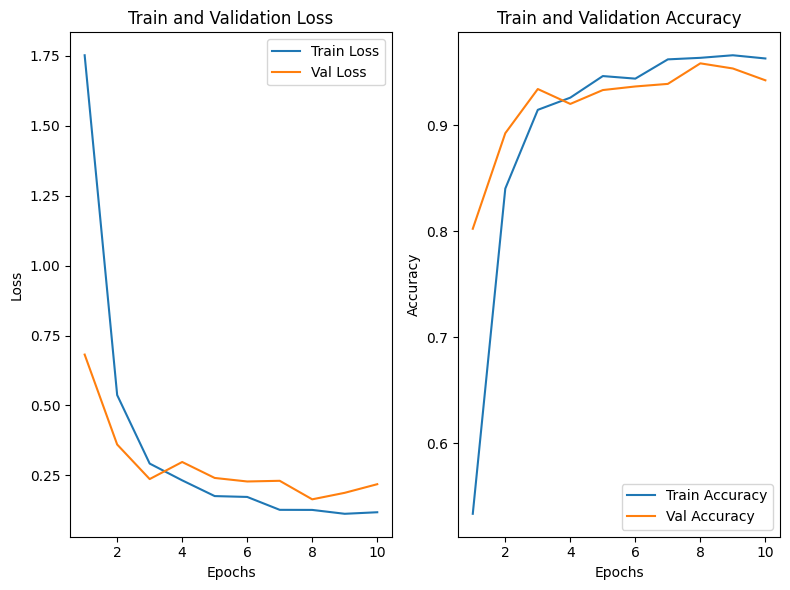

In [ ]:
from tqdm import tqdm

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    running_train_loss = 0.0
    running_val_loss = 0.0
    correct_train = 0
    total_train = 0
    correct_val = 0
    total_val = 0

    for images, labels in tqdm(train_loader, desc = "Training", leave = True):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc = "Validating", leave = True):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_val_loss = running_val_loss / len(test_loader)
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_val_loss)

    epoch_train_acc = correct_train / total_train
    epoch_val_acc = correct_val / total_val
    train_acc.append(epoch_train_acc)
    valid_acc.append(epoch_val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

    if epoch_val_loss < best_valid_loss:
        best_valid_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model_FT_feather_b7.pth')
        print(f"Model weights saved for epoch {epoch + 1} with validation loss: {best_valid_loss:.4f}")

    # Clear CUDA cache
    torch.cuda.empty_cache()

print(f"Batch size: {BATCH_SIZE}, Learning rate: {lr}, Number of epochs: {num_epochs}")
print(f"Best training accuracy: {max(train_acc):.2f}%")
print(f"Best validation accuracy: {max(valid_acc):.2f}%")
print("Plots for current hyperparameter combination:")
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6))
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, valid_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, valid_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
